# Resilience study

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score , precision_score, recall_score, f1_score,\
            precision_recall_curve, confusion_matrix, plot_confusion_matrix

import pickle

## Loading the dataset with selected features and target

In [95]:
dataset = pd.read_csv('./covid_dataset_sel.csv', index_col = 0, dtype = {'ID': str, 'RESILIENT_W1234': str})
dataset.head()

,ID,Edad,Sexo,Zona_vivienda,Pertenencia_vecindario,Comodidad_vencindario_llaves,Comodidad_vencindario_compra,Titulación,Situación_laboral,Adultos_vivienda,...,OFS_total,BRS_total,DAI_TOTAL,IUS_total,PEMBERTON_TOTAL,PI_total,PGT_SF_total,JTC_COVID,JTC_GENERAL,RESILIENT_W1234
0,1020597,47.0,Masculino,Urbana,Moderadamente,Algo cómodo,Algo cómodo,Formación profesional,Empleado tiempo completo,4,...,39.0,3.333333,15.0,33.0,6.833333,3.666667,36.0,2.5,1.0,0999
1,106149,47.0,Femenino,Rural,Ligeramente,Algo cómodo,Muy cómodo,Licenciatura,Empleado tiempo completo,2,...,45.0,3.666667,5.0,20.0,8.750000,3.166667,30.0,4.5,5.0,0999
2,1077997,73.0,Masculino,Rural,Mucho,Muy cómodo,Muy cómodo,Doctorado,Jubilado,2,...,47.0,4.666667,8.0,27.0,9.166667,3.833333,48.0,1.0,5.0,0999
3,1181910,49.0,Femenino,Urbana,Moderadamente,Muy cómodo,Muy cómodo,Formación profesional,Empleado tiempo completo,2,...,43.0,3.500000,10.0,24.0,7.416667,2.833333,41.0,1.0,2.0,0999
4,1469056,25.0,Femenino,Rural,Moderadamente,Algo cómodo,Algo cómodo,Formación profesional,Empleado medio tiempo,3,...,31.0,3.000000,20.0,28.0,5.333333,2.666667,25.0,1.5,1.5,1999


In [96]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 1950
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                1944 non-null   object 
 1   Edad                              1944 non-null   float64
 2   Sexo                              1944 non-null   object 
 3   Zona_vivienda                     1944 non-null   object 
 4   Pertenencia_vecindario            1944 non-null   object 
 5   Comodidad_vencindario_llaves      1944 non-null   object 
 6   Comodidad_vencindario_compra      1944 non-null   object 
 7   Titulación                        1944 non-null   object 
 8   Situación_laboral                 1944 non-null   object 
 9   Adultos_vivienda                  1944 non-null   object 
 10  Menores_vivienda                  1944 non-null   int64  
 11  Descripción_lugar_vivienda        1944 non-null   object 
 12  Ingres

### Defining the target
The presence of distress was conceptualized as meeting standard cut-off scores in depression (PHQ-9), anxiety (GAD-7) or post-traumatic stress severity (ITQ). Although not of diagnostic value, this procedure allows for the identification of probable cases of psychological disorders.

Then, a mental health status classification was carried out by first, categorizing individuals according to whether they exhibited absence/presence of distress (i.e., reaching cutoff scores for either depression, anxiety or posttraumatic responses) and second, taking into account the assessment time-point (i.e., T1 and T2).

The combination of these two variables provided four different categories that tap the pattern of responses after traumatic events (Bonanno, 2004; Galatzer-Levy et al., 2018):
- Recovered (i.e., presence of distress at T1, absence at T2)
- Resilient (i.e., absence of distress at T1 and T2)
- Sustained distress (i.e., presence of distress at T1 and T2)
- Delayed distress (i.e., absence of distress at T1, presence at T2)

With this definition, lets create a new column `target_cat` from `RESILIENT_W1234`, given that:
- `9` means individual did not taket part of that wave survey.
- `0` means absence of distress (under cut-off point using `GAD7`, `PHQ9` and `ITQ`subscales)
- `1` means presence of distress (over cut-off point using `GAD7`, `PHQ9` and `ITQ`subscales)

In [97]:
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '00', 'target_cat'] = 'Resilient'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '10', 'target_cat'] = 'Recovered'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '11', 'target_cat'] = 'Sustained distress'
dataset.loc[dataset['RESILIENT_W1234'].apply(lambda x: x[0:2]) == '01', 'target_cat'] = 'Delayed distress'

In [98]:
# lets drop rows where at least one value is missing (will come just from this last column we created)
dataset.dropna(inplace = True)

In [99]:
dataset['target_cat'].value_counts()

Resilient             886
Sustained distress    419
Delayed distress      175
Recovered             144
Name: target_cat, dtype: int64

In [100]:
# lets create the final target 1 ('Resilient' + 'Recovered')
dataset['target_num'] = [1 if x in ['Resilient', 'Recovered'] else 0 for x in dataset['target_cat']]
dataset

,ID,Edad,Sexo,Zona_vivienda,Pertenencia_vecindario,Comodidad_vencindario_llaves,Comodidad_vencindario_compra,Titulación,Situación_laboral,Adultos_vivienda,...,DAI_TOTAL,IUS_total,PEMBERTON_TOTAL,PI_total,PGT_SF_total,JTC_COVID,JTC_GENERAL,RESILIENT_W1234,target_cat,target_num
323,1017726,42.0,Femenino,Urbana,Mucho,Muy incómodo,Algo cómodo,Master,Empleado tiempo completo,2,...,20.0,52.0,6.500000,1.666667,19.0,1.0,1.0,1199,Sustained distress,0
324,108162,46.0,Femenino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Licenciatura,Empleado medio tiempo,2,...,10.0,25.0,8.083333,4.166667,39.0,1.0,2.0,1199,Sustained distress,0
325,1111859,55.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Licenciatura,Empleado tiempo completo,2,...,11.0,21.0,7.666667,4.500000,36.0,8.5,7.5,0099,Resilient,1
326,1119736,59.0,Femenino,Urbana,Ligeramente,Algo cómodo,Algo cómodo,Master,Empleado medio tiempo,3,...,15.0,17.0,5.916667,3.333333,56.0,1.0,1.0,0099,Resilient,1
327,1151720,22.0,Femenino,Urbana,Moderadamente,Muy incómodo,Algo incómodo,Master,Estudiante,4,...,15.0,31.0,8.750000,3.333333,47.0,1.0,1.5,1099,Recovered,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,996007,45.0,Masculino,Urbana,Ligeramente,Algo incómodo,Algo incómodo,Grado universitario,Empleado tiempo completo,2,...,15.0,25.0,8.416667,2.333333,32.0,5.5,1.0,0000,Resilient,1
1947,997159,25.0,Masculino,Urbana,Moderadamente,Algo cómodo,Algo incómodo,Grado universitario,Empleado medio tiempo,2,...,5.0,32.0,6.833333,2.666667,33.0,3.0,3.5,0100,Delayed distress,0
1948,997683,67.0,Masculino,Rural,Mucho,Muy cómodo,Muy cómodo,Bachillerato,Jubilado,2,...,6.0,27.0,8.333333,3.666667,39.0,1.0,1.0,0000,Resilient,1
1949,997717,31.0,Masculino,Urbana,Ligeramente,Algo cómodo,Algo incómodo,Master,Empleado tiempo completo,2,...,15.0,47.0,5.416667,2.333333,32.0,5.5,2.0,0101,Delayed distress,0


In [101]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1624 entries, 323 to 1950
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                1624 non-null   object 
 1   Edad                              1624 non-null   float64
 2   Sexo                              1624 non-null   object 
 3   Zona_vivienda                     1624 non-null   object 
 4   Pertenencia_vecindario            1624 non-null   object 
 5   Comodidad_vencindario_llaves      1624 non-null   object 
 6   Comodidad_vencindario_compra      1624 non-null   object 
 7   Titulación                        1624 non-null   object 
 8   Situación_laboral                 1624 non-null   object 
 9   Adultos_vivienda                  1624 non-null   object 
 10  Menores_vivienda                  1624 non-null   int64  
 11  Descripción_lugar_vivienda        1624 non-null   object 
 12  Ingr

### Overall probability of default

In [102]:
dataset['target_num'].mean()

0.6342364532019704

So we are not dealing with an umbalanced problem.

### Creating a modeling pipeline

In [103]:
#separating target and features and droping features used to calculate target
target = dataset['target_num']
features = dataset.drop(['ID', 'PHQ_15_TOTAL', 'PHQ_9_TOTAL', 'GAD_TOTAL',
                         'PTSD_REEXP',
                         'PTSD_AVOID',
                         'PTSD_THREAT',
                         'PTSD_SEVERITY',
                         'PTSD_IMPAIR',
                         'PTSD_DIAGNOSIS',
                         'PTSD_TOTAL',
                         'SUBST_STRESS',
                         'DEP_DIAGN',
                         'RESILIENT_W1234', 'target_cat', 'target_num'], axis = 1)

#defining classifier
#classifier = LogisticRegression(max_iter = 10000)
#classifier = DecisionTreeClassifier(min_samples_leaf = 40, min_samples_split = 100, max_depth = 4)
#classifier = RandomForestClassifier(n_estimators = 10000,
#                                    min_samples_leaf = 40,
#                                    min_samples_split = 110,
#                                    max_depth = 6,
#                                    max_features = 10)
rf = RandomForestClassifier()

#parameters grid to hypertune
random_param_grid = {'n_estimators': range(100, 1100, 100),
                     'min_samples_leaf': range(30, 90, 10),
                     'min_samples_split': range(90, 140, 10),
                     'max_depth': range(5, 10, 1),
                     'max_features': range(10, 35, 5)
                     }

#random search of parameters, using 3 fold cross validation, search across 100 different combinations
#use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_param_grid,
                               n_iter = 500,
                               cv = 3,
                               random_state = 0,
                               scoring = 'accuracy')

#separating numeric and categorical features
features_string = features.select_dtypes('object').columns
features_numeric = features.select_dtypes('number').columns

#defining preprocessing for categorical and numerical features 
preproc = ColumnTransformer([('string_preproc', TargetEncoder(), features_string), 
                             ('numeric_preproc', StandardScaler(), features_numeric)])

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0)

#fit the random search model after applying preproc to features
rf_random.fit(preproc.fit_transform(X_train, y_train), y_train)

rf_best = rf_random.best_estimator_

#creating the modeling pipeline
pipeline = Pipeline([('preproc', preproc),
                     ('classifier', rf_best)])
pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('string_preproc',
                                                  TargetEncoder(),
                                                  Index(['Sexo', 'Zona_vivienda', 'Pertenencia_vecindario',
       'Comodidad_vencindario_llaves', 'Comodidad_vencindario_compra',
       'Titulación', 'Situación_laboral', 'Adultos_vivienda',
       'Descripción_lugar_vivienda', 'Ingresos', 'pérdida_ingresos',
       'preocupación_economía_covid'...
       'COVID_TRANSMISSION', 'COVID_ENGAGEMENT', 'SUBSTANCE_SCORE',
       'PADS_TOTAL', 'CRT_TOTAL', 'LONELI', 'LMLOS_chance', 'LMLOS_powerful',
       'LMLOS_internal', 'OFS_total', 'BRS_total', 'DAI_TOTAL', 'IUS_total',
       'PEMBERTON_TOTAL', 'PI_total', 'PGT_SF_total', 'JTC_COVID',
       'JTC_GENERAL'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_features=25,
                                        min_sa

last model accuracy_score_test 0.7586206896551724
last model accuracy_score_train 0.7988505747126436
last model precision_score_test 0.7748344370860927
last model precision_score_train 0.8018539976825029
last model recall_score_test 0.8863636363636364
last model recall_score_train 0.9033942558746736
last model f1_score_test 0.8268551236749115
last model f1_score_train 0.8496009821976672
last model auc_score_test 0.7037451984635082
last model auc_score_train 0.7625378359019386


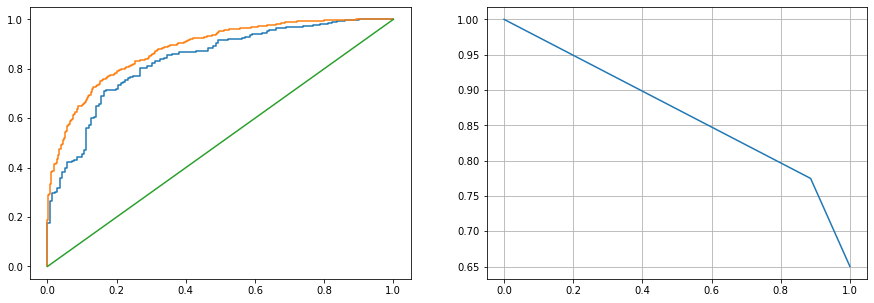

In [104]:
#trainning the model
pipeline.fit(X_train, y_train)

#making predictions
predictions_test = pipeline.predict(X_test)
predictions_proba_test = pipeline.predict_proba(X_test)
predictions_train = pipeline.predict(X_train)
predictions_proba_train = pipeline.predict_proba(X_train)

#evaluating the model
#metrics
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
auc_test = roc_auc_score(y_test, predictions_test)

accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_train = f1_score(y_train, predictions_train)
auc_train = roc_auc_score(y_train, predictions_train)

# print and graph last result
print('last model accuracy_score_test', accuracy_test)
print('last model accuracy_score_train', accuracy_train)
print('last model precision_score_test', precision_test)
print('last model precision_score_train', precision_train)
print('last model recall_score_test', recall_test)
print('last model recall_score_train', recall_train)
print('last model f1_score_test', f1_test)
print('last model f1_score_train', f1_train)
print('last model auc_score_test', auc_test)
print('last model auc_score_train', auc_train)

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
roc_rf_test = roc_curve(y_test, predictions_proba_test[:,1])
roc_rf_train = roc_curve(y_train, predictions_proba_train[:,1])

#plotting results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(roc_rf_test[0], roc_rf_test[1]);
ax[0].plot(roc_rf_train[0], roc_rf_train[1]);
ax[0].plot([0, 1], [0, 1]);

ax[1].plot(recall, precision)
ax[1].grid()

In [105]:
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
209,0.622397,0.002572,0.034857,0.000964,300,100,30,25,5,"{'n_estimators': 300, 'min_samples_split': 100...",0.748768,0.756158,0.756158,0.753695,0.003483,1
254,0.327953,0.002856,0.022735,0.000199,200,100,30,15,5,"{'n_estimators': 200, 'min_samples_split': 100...",0.743842,0.763547,0.753695,0.753695,0.008044,2
292,0.362592,0.002250,0.022226,0.000577,200,120,70,25,9,"{'n_estimators': 200, 'min_samples_split': 120...",0.753695,0.743842,0.761084,0.752874,0.007063,3
58,0.220687,0.001838,0.011648,0.000564,100,110,30,30,9,"{'n_estimators': 100, 'min_samples_split': 110...",0.751232,0.751232,0.756158,0.752874,0.002322,3
106,0.709196,0.025106,0.041729,0.000570,400,130,70,25,9,"{'n_estimators': 400, 'min_samples_split': 130...",0.748768,0.753695,0.756158,0.752874,0.003072,3
272,1.466617,0.011415,0.080034,0.000717,700,90,40,25,6,"{'n_estimators': 700, 'min_samples_split': 90,...",0.743842,0.753695,0.758621,0.752053,0.006144,6
397,1.057078,0.008014,0.066571,0.002328,600,120,80,25,7,"{'n_estimators': 600, 'min_samples_split': 120...",0.753695,0.741379,0.761084,0.752053,0.008128,6
107,0.453073,0.038569,0.032921,0.000788,300,130,30,10,5,"{'n_estimators': 300, 'min_samples_split': 130...",0.753695,0.753695,0.748768,0.752053,0.002322,6
301,1.132669,0.027896,0.056170,0.002415,500,110,30,30,8,"{'n_estimators': 500, 'min_samples_split': 110...",0.746305,0.751232,0.758621,0.752053,0.005061,6
101,0.948383,0.037681,0.048650,0.004423,400,100,30,30,7,"{'n_estimators': 400, 'min_samples_split': 100...",0.748768,0.751232,0.756158,0.752053,0.003072,6


In [106]:
cm = confusion_matrix(y_test, predictions_test)
print(cm)

[[ 74  68]
 [ 30 234]]


In [107]:
pipeline.steps[1][1]

RandomForestClassifier(max_depth=5, max_features=25, min_samples_leaf=30,
                       min_samples_split=100, n_estimators=300)

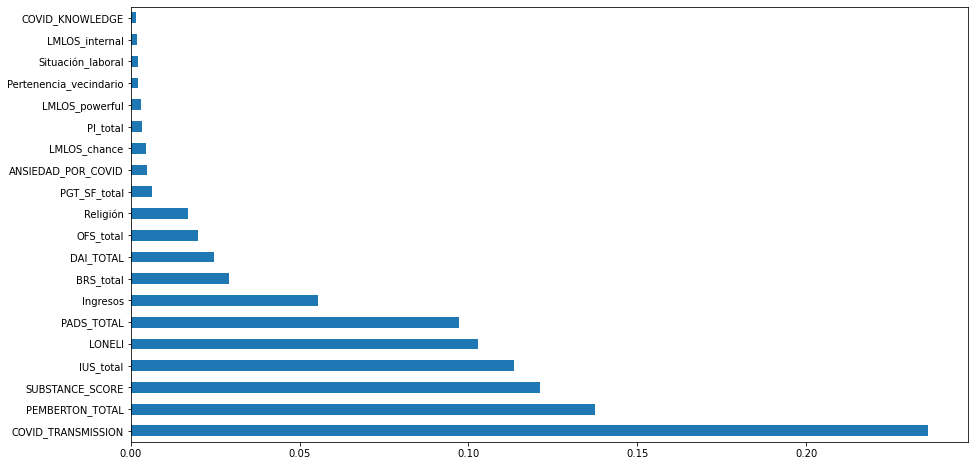

In [108]:
columns_importance = pd.Series(pipeline.steps[1][1].feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(20).plot(kind = 'barh');

In [109]:
#lets save the model to disk
filename = './RandomForestClassifier_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

### Building a general (no COVID features) model for resilience

In [110]:
#separating target and features and keeping most important features from previous step
target = dataset['target_num']
features = dataset.drop(['ID', 'PHQ_15_TOTAL', 'PHQ_9_TOTAL', 'GAD_TOTAL',
                         'PTSD_REEXP',
                         'PTSD_AVOID',
                         'PTSD_THREAT',
                         'PTSD_SEVERITY',
                         'PTSD_IMPAIR',
                         'PTSD_DIAGNOSIS',
                         'PTSD_TOTAL',
                         'SUBST_STRESS',
                         'DEP_DIAGN',
                         'pérdida_ingresos', 'preocupación_economía_covid', 'ANSIEDAD_POR_COVID', 'COVID_KNOWLEDGE', 'COVID_TRANSMISSION', 'COVID_ENGAGEMENT', 'VACUNA_USTED', 'JTC_COVID',
                         'RESILIENT_W1234', 'target_cat', 'target_num'], axis = 1)

#defining classifier
#classifier = LogisticRegression(max_iter = 10000)
#classifier = DecisionTreeClassifier(min_samples_leaf = 40, min_samples_split = 100, max_depth = 4)
#classifier = RandomForestClassifier(n_estimators = 10000,
#                                    min_samples_leaf = 40,
#                                    min_samples_split = 110,
#                                    max_depth = 6,
#                                    max_features = 10)
rf = RandomForestClassifier()

#parameters grid to hypertune
random_param_grid = {'n_estimators': range(100, 1100, 100),
                     'min_samples_leaf': range(30, 90, 10),
                     'min_samples_split': range(90, 140, 10),
                     'max_depth': range(5, 10, 1),
                     'max_features': range(10, 35, 5)
                     }

#random search of parameters, using 3 fold cross validation, search across 100 different combinations
#use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_param_grid,
                               n_iter = 500,
                               cv = 3,
                               random_state = 0,
                               scoring = 'accuracy')

#separating numeric and categorical features
features_string = features.select_dtypes('object').columns
features_numeric = features.select_dtypes('number').columns

#defining preprocessing for categorical and numerical features 
preproc = ColumnTransformer([('string_preproc', TargetEncoder(), features_string), 
                             ('numeric_preproc', StandardScaler(), features_numeric)])

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0)

#fit the random search model after applying preproc to features
rf_random.fit(preproc.fit_transform(X_train, y_train), y_train)

rf_best = rf_random.best_estimator_

#creating the modeling pipeline
pipeline = Pipeline([('preproc', preproc),
                     ('classifier', rf_best)])
pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('string_preproc',
                                                  TargetEncoder(),
                                                  Index(['Sexo', 'Zona_vivienda', 'Pertenencia_vecindario',
       'Comodidad_vencindario_llaves', 'Comodidad_vencindario_compra',
       'Titulación', 'Situación_laboral', 'Adultos_vivienda',
       'Descripción_lugar_vivienda', 'Ingresos', 'Religión',
       'CONFIANZA_EN_OTROS', 'AISLAMIENTO'],
      d...
       'Teorías_de_la_conspiración', 'SUBSTANCE_SCORE', 'PADS_TOTAL',
       'CRT_TOTAL', 'LONELI', 'LMLOS_chance', 'LMLOS_powerful',
       'LMLOS_internal', 'OFS_total', 'BRS_total', 'DAI_TOTAL', 'IUS_total',
       'PEMBERTON_TOTAL', 'PI_total', 'PGT_SF_total', 'JTC_GENERAL'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_features=10,
                                        min_samples_leaf=30,
         

last model accuracy_score_test 0.7487684729064039
last model accuracy_score_train 0.7750410509031199
last model precision_score_test 0.7579617834394905
last model precision_score_train 0.7739420935412027
last model recall_score_test 0.9015151515151515
last model recall_score_train 0.9073107049608355
last model f1_score_test 0.823529411764706
last model f1_score_train 0.8353365384615385
last model auc_score_test 0.6831519419547588
last model auc_score_train 0.729097830356524


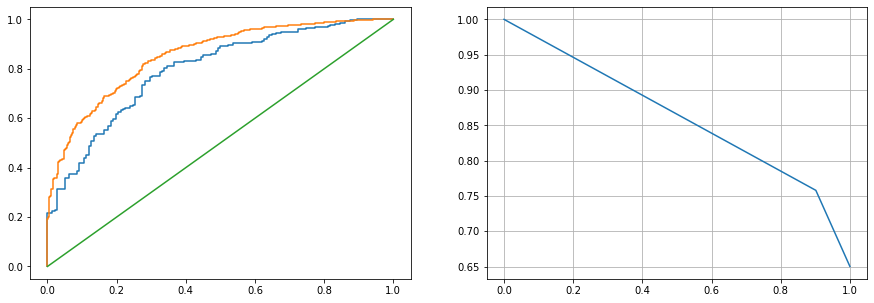

In [111]:
#trainning the model
pipeline.fit(X_train, y_train)

#making predictions
predictions_test = pipeline.predict(X_test)
predictions_proba_test = pipeline.predict_proba(X_test)
predictions_train = pipeline.predict(X_train)
predictions_proba_train = pipeline.predict_proba(X_train)

#evaluating the model
#metrics
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
auc_test = roc_auc_score(y_test, predictions_test)

accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_train = f1_score(y_train, predictions_train)
auc_train = roc_auc_score(y_train, predictions_train)

# print and graph last result
print('last model accuracy_score_test', accuracy_test)
print('last model accuracy_score_train', accuracy_train)
print('last model precision_score_test', precision_test)
print('last model precision_score_train', precision_train)
print('last model recall_score_test', recall_test)
print('last model recall_score_train', recall_train)
print('last model f1_score_test', f1_test)
print('last model f1_score_train', f1_train)
print('last model auc_score_test', auc_test)
print('last model auc_score_train', auc_train)

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
roc_rf_test = roc_curve(y_test, predictions_proba_test[:,1])
roc_rf_train = roc_curve(y_train, predictions_proba_train[:,1])

#plotting results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(roc_rf_test[0], roc_rf_test[1]);
ax[0].plot(roc_rf_train[0], roc_rf_train[1]);
ax[0].plot([0, 1], [0, 1]);

ax[1].plot(recall, precision)
ax[1].grid()

In [112]:
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
262,1.351895,0.009552,0.102738,0.000748,1000,110,30,10,5,"{'n_estimators': 1000, 'min_samples_split': 11...",0.751232,0.733990,0.756158,0.747126,0.009504,1
178,0.266965,0.002946,0.020827,0.000347,200,130,30,10,9,"{'n_estimators': 200, 'min_samples_split': 130...",0.746305,0.736453,0.753695,0.745484,0.007063,2
196,1.054105,0.052588,0.077470,0.005113,700,110,30,10,6,"{'n_estimators': 700, 'min_samples_split': 110...",0.743842,0.736453,0.751232,0.743842,0.006033,3
214,0.814728,0.101513,0.054851,0.005089,500,120,30,10,7,"{'n_estimators': 500, 'min_samples_split': 120...",0.743842,0.731527,0.756158,0.743842,0.010055,3
107,0.495463,0.110882,0.037469,0.008447,300,130,30,10,5,"{'n_estimators': 300, 'min_samples_split': 130...",0.743842,0.733990,0.751232,0.743021,0.007063,5
187,0.335357,0.007378,0.025383,0.001915,200,110,30,10,7,"{'n_estimators': 200, 'min_samples_split': 110...",0.746305,0.731527,0.748768,0.742200,0.007614,6
441,0.734878,0.005678,0.055550,0.000436,500,120,30,10,8,"{'n_estimators': 500, 'min_samples_split': 120...",0.733990,0.733990,0.758621,0.742200,0.011611,6
237,0.306270,0.002554,0.020986,0.000055,200,100,40,15,9,"{'n_estimators': 200, 'min_samples_split': 100...",0.738916,0.733990,0.753695,0.742200,0.008373,6
249,0.312127,0.001725,0.021158,0.000271,200,100,30,15,6,"{'n_estimators': 200, 'min_samples_split': 100...",0.741379,0.726601,0.756158,0.741379,0.012066,9
302,0.740210,0.076980,0.051838,0.000463,500,100,30,10,6,"{'n_estimators': 500, 'min_samples_split': 100...",0.738916,0.731527,0.753695,0.741379,0.009216,9


In [113]:
cm = confusion_matrix(y_test, predictions_test)
print(cm)

[[ 66  76]
 [ 26 238]]


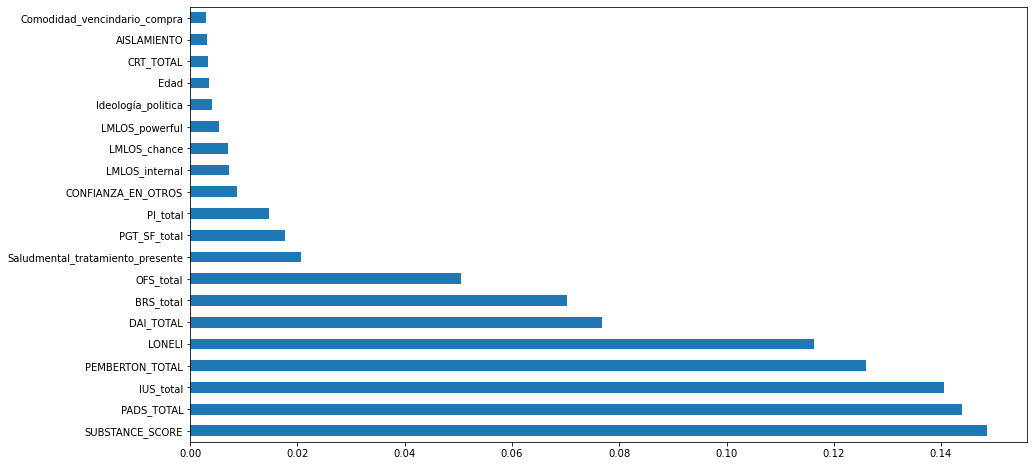

In [114]:
columns_importance = pd.Series(pipeline.steps[1][1].feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(20).plot(kind = 'barh');

In [115]:
#lets save the model to disk
filename = './RandomForestClassifier_NoCovidFeatures_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

### Building a model for a resilience prediction webapp (just the most relevant features to keep a friendly user interaction time on the app)

In [116]:
#separating target and features and keeping most important features from previous step
target = dataset['target_num']
features = dataset[['SUBSTANCE_SCORE',
                    'PADS_TOTAL',
                    'IUS_total',
                    'PEMBERTON_TOTAL',
                    'LONELI',
                    'DAI_TOTAL',
                    'BRS_total',
                    'OFS_total']]

#defining classifier
#classifier = LogisticRegression(max_iter = 10000)
#classifier = DecisionTreeClassifier(min_samples_leaf = 40, min_samples_split = 100, max_depth = 4)
#classifier = RandomForestClassifier(n_estimators = 10000,
#                                    min_samples_leaf = 40,
#                                    min_samples_split = 110,
#                                    max_depth = 6,
#                                    max_features = 10)
rf = RandomForestClassifier()

#parameters grid to hypertune
random_param_grid = {'n_estimators': range(100, 1100, 100),
                     'min_samples_leaf': range(30, 90, 10),
                     'min_samples_split': range(90, 140, 10),
                     'max_depth': range(3, 9, 1)
                     }

#random search of parameters, using 3 fold cross validation, search across 100 different combinations
#use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_param_grid,
                               n_iter = 500,
                               cv = 3,
                               random_state = 0,
                               scoring = 'accuracy')

#separating numeric and categorical features
features_string = features.select_dtypes('object').columns
features_numeric = features.select_dtypes('number').columns

#defining preprocessing for categorical and numerical features 
preproc = ColumnTransformer([('string_preproc', TargetEncoder(), features_string), 
                             ('numeric_preproc', StandardScaler(), features_numeric)])

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0)

#fit the random search model after applying preproc to features
rf_random.fit(preproc.fit_transform(X_train, y_train), y_train)

rf_best = rf_random.best_estimator_

#creating the modeling pipeline
pipeline = Pipeline([('preproc', preproc),
                     ('classifier', rf_best)])
pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('string_preproc',
                                                  TargetEncoder(),
                                                  Index([], dtype='object')),
                                                 ('numeric_preproc',
                                                  StandardScaler(),
                                                  Index(['SUBSTANCE_SCORE', 'PADS_TOTAL', 'IUS_total', 'PEMBERTON_TOTAL',
       'LONELI', 'DAI_TOTAL', 'BRS_total', 'OFS_total'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=40,
                                        min_samples_split=100,
                                        n_estimators=200))])

last model accuracy_score_test 0.7463054187192119
last model accuracy_score_train 0.7676518883415435
last model precision_score_test 0.7605177993527508
last model precision_score_train 0.7698324022346369
last model recall_score_test 0.8901515151515151
last model recall_score_train 0.8994778067885117
last model f1_score_test 0.8202443280977313
last model f1_score_train 0.8296207104154124
last model auc_score_test 0.6845123772940674
last model auc_score_train 0.7218627971995657


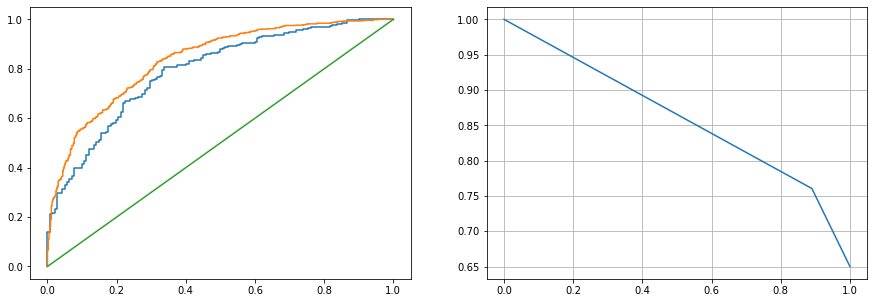

In [117]:
#trainning the model
pipeline.fit(X_train, y_train)

#making predictions
predictions_test = pipeline.predict(X_test)
predictions_proba_test = pipeline.predict_proba(X_test)
predictions_train = pipeline.predict(X_train)
predictions_proba_train = pipeline.predict_proba(X_train)

#evaluating the model
#metrics
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
auc_test = roc_auc_score(y_test, predictions_test)

accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_train = f1_score(y_train, predictions_train)
auc_train = roc_auc_score(y_train, predictions_train)

# print and graph last result
print('last model accuracy_score_test', accuracy_test)
print('last model accuracy_score_train', accuracy_train)
print('last model precision_score_test', precision_test)
print('last model precision_score_train', precision_train)
print('last model recall_score_test', recall_test)
print('last model recall_score_train', recall_train)
print('last model f1_score_test', f1_test)
print('last model f1_score_train', f1_train)
print('last model auc_score_test', auc_test)
print('last model auc_score_train', auc_train)

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
roc_rf_test = roc_curve(y_test, predictions_proba_test[:,1])
roc_rf_train = roc_curve(y_train, predictions_proba_train[:,1])

#plotting results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(roc_rf_test[0], roc_rf_test[1]);
ax[0].plot(roc_rf_train[0], roc_rf_train[1]);
ax[0].plot([0, 1], [0, 1]);

ax[1].plot(recall, precision)
ax[1].grid()

In [118]:
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
56,0.225012,0.002567,0.020689,0.000081,200,100,40,8,"{'n_estimators': 200, 'min_samples_split': 100...",0.741379,0.743842,0.768473,0.751232,0.012233,1
254,0.239850,0.000738,0.022400,0.000290,200,90,40,5,"{'n_estimators': 200, 'min_samples_split': 90,...",0.746305,0.746305,0.758621,0.750411,0.005805,2
395,0.236174,0.002809,0.022145,0.000199,200,130,30,5,"{'n_estimators': 200, 'min_samples_split': 130...",0.738916,0.746305,0.766010,0.750411,0.011435,2
256,0.590984,0.001493,0.055905,0.000821,500,130,30,6,"{'n_estimators': 500, 'min_samples_split': 130...",0.738916,0.743842,0.766010,0.749589,0.011784,4
31,0.456774,0.007859,0.042468,0.000794,400,90,30,4,"{'n_estimators': 400, 'min_samples_split': 90,...",0.741379,0.743842,0.763547,0.749589,0.009920,4
276,0.363256,0.001701,0.033531,0.000192,300,110,30,7,"{'n_estimators': 300, 'min_samples_split': 110...",0.746305,0.733990,0.766010,0.748768,0.013188,6
81,0.237917,0.002323,0.022783,0.000871,200,120,40,4,"{'n_estimators': 200, 'min_samples_split': 120...",0.736453,0.748768,0.761084,0.748768,0.010055,6
293,1.076750,0.006536,0.099676,0.000776,900,110,30,7,"{'n_estimators': 900, 'min_samples_split': 110...",0.741379,0.741379,0.763547,0.748768,0.010450,6
397,0.947220,0.007102,0.086780,0.000600,800,110,30,8,"{'n_estimators': 800, 'min_samples_split': 110...",0.736453,0.743842,0.763547,0.747947,0.011435,9
360,0.493662,0.015348,0.044565,0.000978,400,90,30,7,"{'n_estimators': 400, 'min_samples_split': 90,...",0.736453,0.738916,0.768473,0.747947,0.014548,9


In [119]:
cm = confusion_matrix(y_test, predictions_test)
print(cm)

[[ 68  74]
 [ 29 235]]


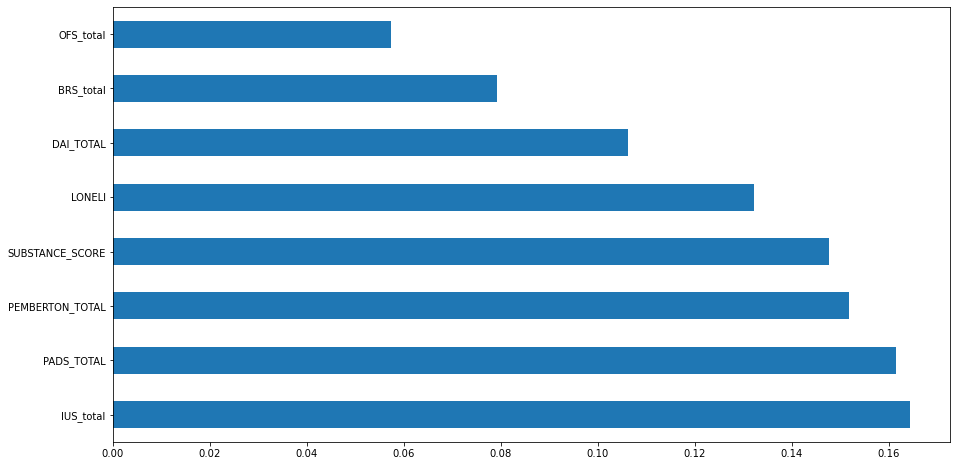

In [120]:
columns_importance = pd.Series(pipeline.steps[1][1].feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(20).plot(kind = 'barh');

In [121]:
#lets save the model to disk
filename = './RandomForestClassifier_NoCovidFeatures_Webapp_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

### Adding a method to interpret RF classifier and be able to give feedback to user in webapp

In [ ]:
#load the model from disk
filename = './DecisionTreeClassifier_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
loaded_model.steps[1][1]

In [ ]:
columns_importance = pd.Series(loaded_model.steps[1][1].feature_importances_, index=features.columns)
fig = plt.figure(figsize = (15, 8))
columns_importance.nlargest(10).plot(kind = 'barh');

In [ ]:
plt.figure(figsize = (20,20))
plot_tree(loaded_model.steps[1][1],
              feature_names = features.columns.values,
              class_names = ['No', 'Sí'],
              filled = True,
              impurity = False,
              fontsize = 8)
plt.show()